Требуется кластеризация клиентов для определения маркетинговой стратегии. Набор данных обобщает информацию об использовании примерно 9000 активных кредитных карт за последние 6 месяцев. Файл содержит 18 поведенческих переменных для каждого клиента.

Ниже приведен словарь данных для набора данных кредитных карт:

CUST_ID: идентификатор держателя кредитной карты
BALANCE: баланс на счете для совершения покупок
BALANCE_FREQUENCY: как часто обновляется баланс, оценка от 0 до 1 (1 = часто обновляется, 0 = не часто обновляется)
PURCHASES: сумма, потраченная на покупки
ONEOFF_PURCHASES: максимальная сумма покупки без рассрочки
INSTALLMENTS_PURCHASES: сумма, потраченная на покупки, совершенные в рассрочку
CASH_ADVANCE: аванс наличными, предоставленный клиенту
PURCHASES_FREQUENCY: частота совершения покупок, оценка от 0 до 1 (1 = часто, 0 = не часто)
ONEOFF_PURCHASES_FREQUENCY: как часто покупки происходят без рассрочки (1 = часто, 0 = не часто)
PURCHASES_INSTALLMENTS_FREQUENCY: частота совершения покупок в рассрочку (1 = часто, 0 = не часто)
CASH_ADVANCE_FREQUENCY: как часто клиенту выплачиваются авансы наличными
CASH_ADVANCE_TRX: количество транзакций, совершенных с помощью функции «Cash in Advanced» (аванс наличными)
PURCHASES_TRX: количество совершенных покупок
CREDIT_LIMIT: лимит кредитной карты для клиента
PAYMENTS: сумма платежей, выполненных клиентом
MINIMUM_PAYMENTS: минимальная сумма платежа, сделанного клиентом
PRC_FULL_PAYMENT: процент средств от общей суммы платежей, уплаченный клиентом
TENURE: срок службы кредитной карты для пользователя

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings(action="ignore")

data = pd.read_csv('CC GENERAL.csv')

Выявляем наличие и расположение пропусков

In [3]:
print(data.isnull().sum().sort_values(ascending=False).head())

MINIMUM_PAYMENTS       313
CREDIT_LIMIT             1
TENURE                   0
PURCHASES_FREQUENCY      0
BALANCE                  0
dtype: int64


Избавляемся от пропусков в данных

In [4]:
data.loc[data['MINIMUM_PAYMENTS'].isnull(), 'MINIMUM_PAYMENTS'] = data['MINIMUM_PAYMENTS'].mean()
data.loc[data['CREDIT_LIMIT'].isnull(), 'CREDIT_LIMIT'] = data['CREDIT_LIMIT'].mean()

"Дискретизация". Компоненты вектора должны быть соизмеримы, иначе показатель inertia в K-means будет лишён смысла

In [5]:
columns = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
           'PAYMENTS', 'MINIMUM_PAYMENTS']
for c in columns:
    Range = c + '_RANGE'
    data[Range] = 0
    data.loc[((data[c] > 0) & (data[c] <= 500)), Range] = 1
    data.loc[((data[c] > 500) & (data[c] <= 1000)), Range] = 2
    data.loc[((data[c] > 1000) & (data[c] <= 3000)), Range] = 3
    data.loc[((data[c] > 3000) & (data[c] <= 5000)), Range] = 4
    data.loc[((data[c] > 5000) & (data[c] <= 10000)), Range] = 5
    data.loc[(data[c] > 10000), Range] = 6

columns = ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
           'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT']
for c in columns:
    Range = c + '_RANGE'
    data[Range] = 0
    data.loc[((data[c] > 0) & (data[c] <= 0.1)), Range] = 1
    data.loc[((data[c] > 0.1) & (data[c] <= 0.2)), Range] = 2
    data.loc[((data[c] > 0.2) & (data[c] <= 0.3)), Range] = 3
    data.loc[((data[c] > 0.3) & (data[c] <= 0.4)), Range] = 4
    data.loc[((data[c] > 0.4) & (data[c] <= 0.5)), Range] = 5
    data.loc[((data[c] > 0.5) & (data[c] <= 0.6)), Range] = 6
    data.loc[((data[c] > 0.6) & (data[c] <= 0.7)), Range] = 7
    data.loc[((data[c] > 0.7) & (data[c] <= 0.8)), Range] = 8
    data.loc[((data[c] > 0.8) & (data[c] <= 0.9)), Range] = 9
    data.loc[((data[c] > 0.9) & (data[c] <= 1.0)), Range] = 10

columns = ['PURCHASES_TRX', 'CASH_ADVANCE_TRX']
for c in columns:
    Range = c + '_RANGE'
    data[Range] = 0
    data.loc[((data[c] > 0) & (data[c] <= 5)), Range] = 1
    data.loc[((data[c] > 5) & (data[c] <= 10)), Range] = 2
    data.loc[((data[c] > 10) & (data[c] <= 15)), Range] = 3
    data.loc[((data[c] > 15) & (data[c] <= 20)), Range] = 4
    data.loc[((data[c] > 20) & (data[c] <= 30)), Range] = 5
    data.loc[((data[c] > 30) & (data[c] <= 50)), Range] = 6
    data.loc[((data[c] > 50) & (data[c] <= 100)), Range] = 7
    data.loc[(data[c] > 100), Range] = 8

Переход к дискретным значениям

In [6]:
data.drop(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
           'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
           'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
           'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
           'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
           'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT'], axis=1, inplace=True)
X = np.asarray(data)

Статистические данные

In [7]:
scale = StandardScaler()
X = scale.fit_transform(X)

Кластеризация

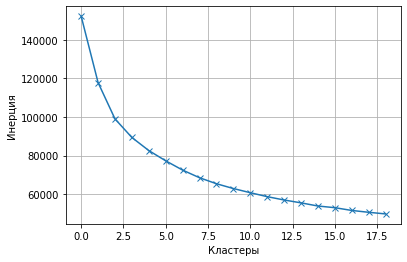

In [8]:
clusters_count = 20
cost = []
for i in range(1, clusters_count):
    kmean = KMeans(i)
    kmean.fit(X)
    cost.append(kmean.inertia_)
plt.xlabel('Кластеры')
plt.ylabel('Инерция')
plt.grid(True)
plt.plot(cost, 'x-')

5 кластеров в самый раз
Распределим данные по кластерам

In [9]:
kmean = KMeans(5)
kmean.fit(X)
labels = kmean.labels_

Добавим номер кластера в главный DataFrame

In [10]:
clusters = pd.concat([data, pd.DataFrame({'cluster': labels})], axis=1)

Анализируем каждый кластер.

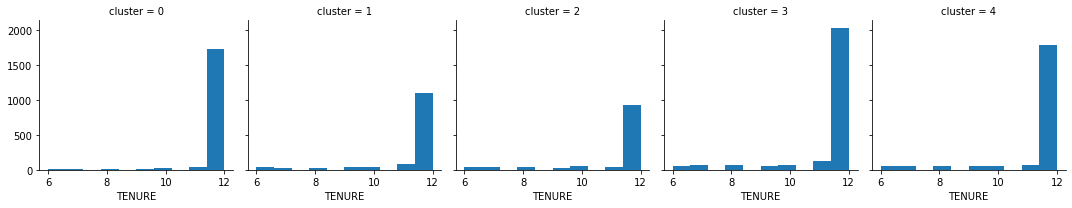

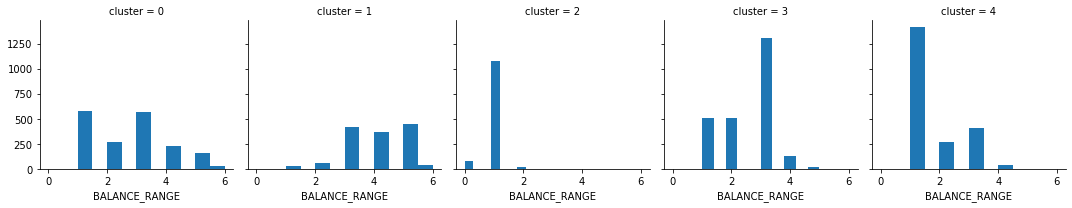

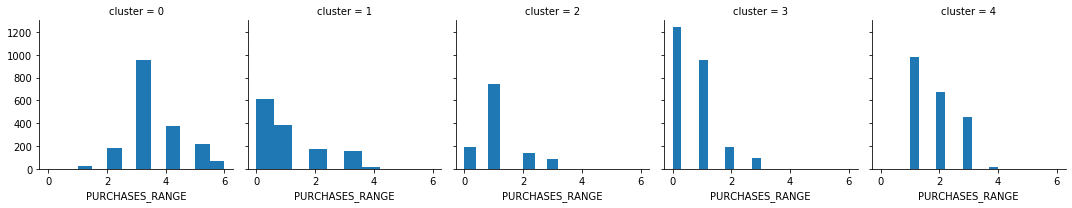

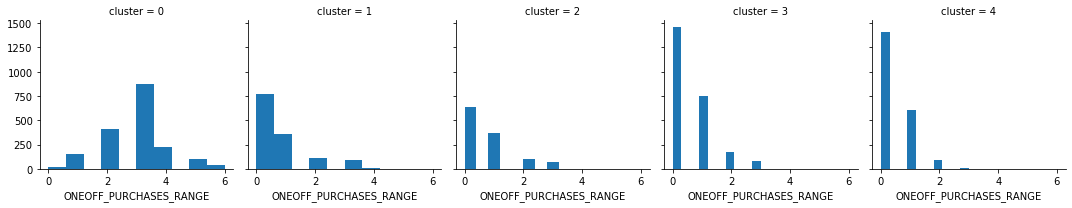

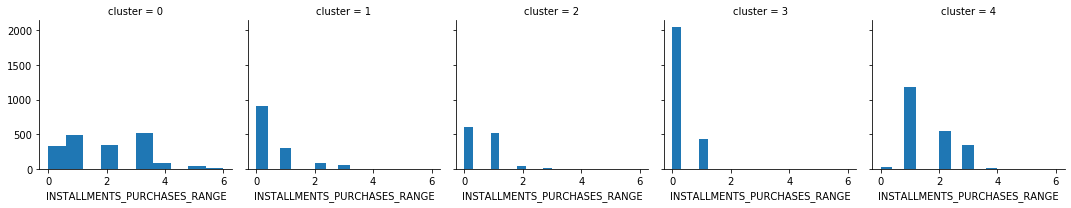

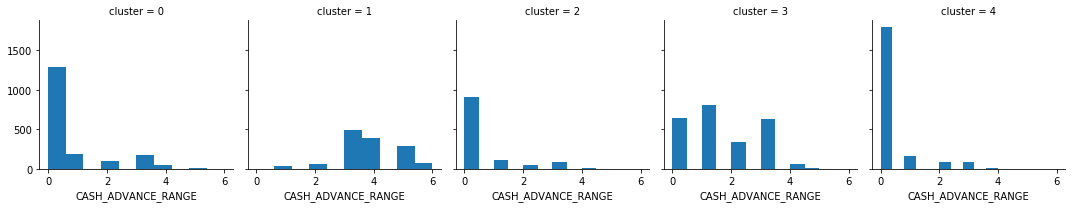

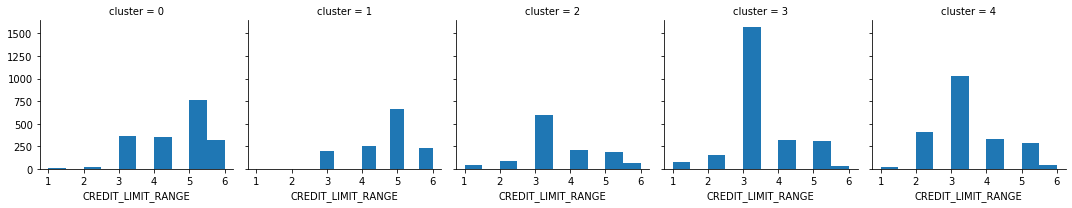

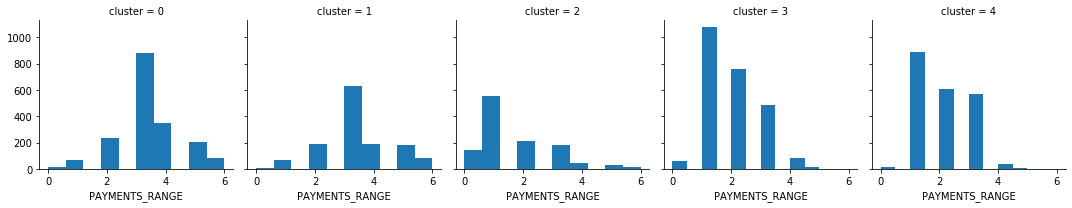

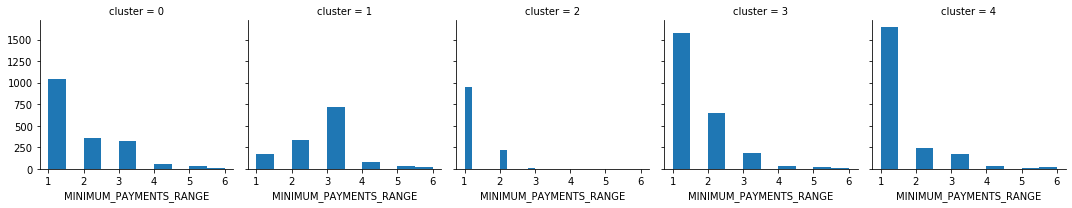

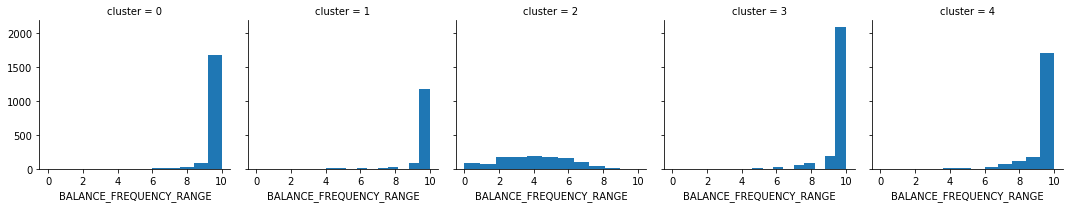

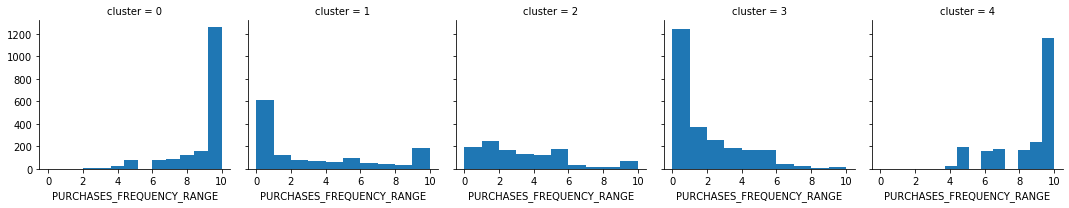

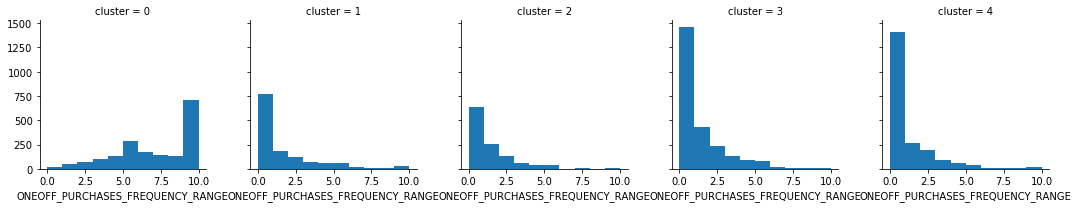

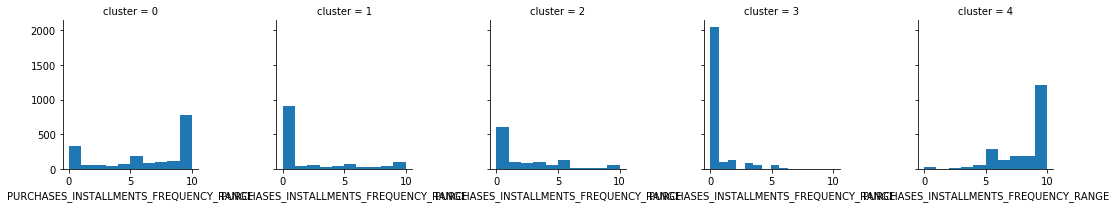

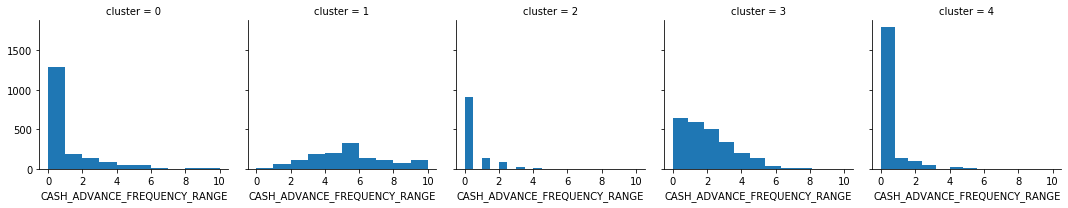

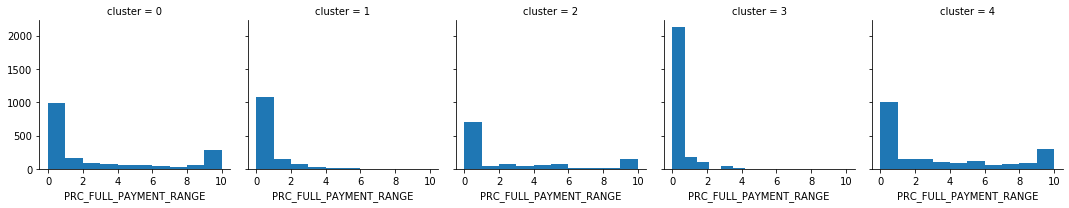

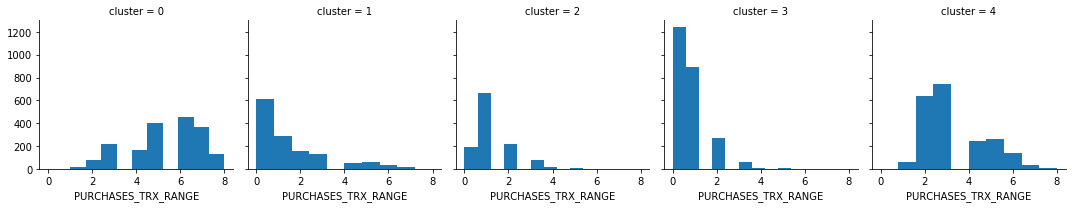

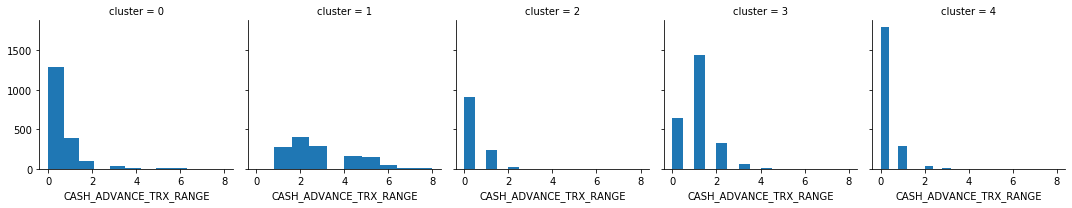

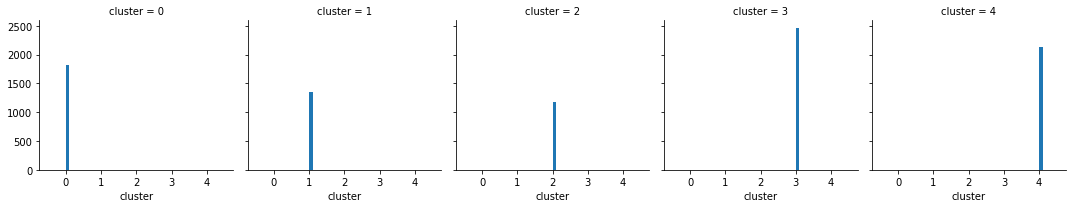

In [11]:
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

Кластеры:
1. Кредитка всегда под рукой. 
    Клиенты с различным балансом, реже высоким, тратят на покупки средние, реже высокие суммы. В рассрочку покупают чаще что-то дешёвое, в основном без рассрочки. Авансы берут редко, часто мелкие. Высокие кредитные лимиты. Покупают часто.

2. Скупые богачи.
    Клиенты с балансом выше среднего, тратят на покупки небольшие суммы. Берут крупные авансы со средней частотой. Кредитные лимиты выше среднего. Высокие минимальные платежи. Доход регулярный. Покупают редко.

3. Редко вспоминают, что у них есть кредитка.
    Клиенты с небольшим балансом, тратят на покупки небольшие суммы. Берут небольшие авансы. Кредитные лимиты разные, преимущественно средние. Низкие минимальные платежи. Покупают редко на разные суммы.

4. Самый средний класс. 
    Клиенты со средним балансом, тратят на покупки небольшие суммы. Берут не слишком крупные авансы. Кредитные лимиты средние. Низкие минимальные платежи. Баланс меняется часто. Покупают редко.
    
5. Низкий доход и частая активность.
    Клиенты с низковатым балансом, тратятся на покупки по возможностям. Берут авансы редко и по чуть-чуть. Кредитные лимиты разные, не особо высокие, у многих даже низковатые. Низкие минимальные платежи. Картой пользуются часто. Покупают часто.

Снизим размерность и визуализируем кластеры на плоскости.

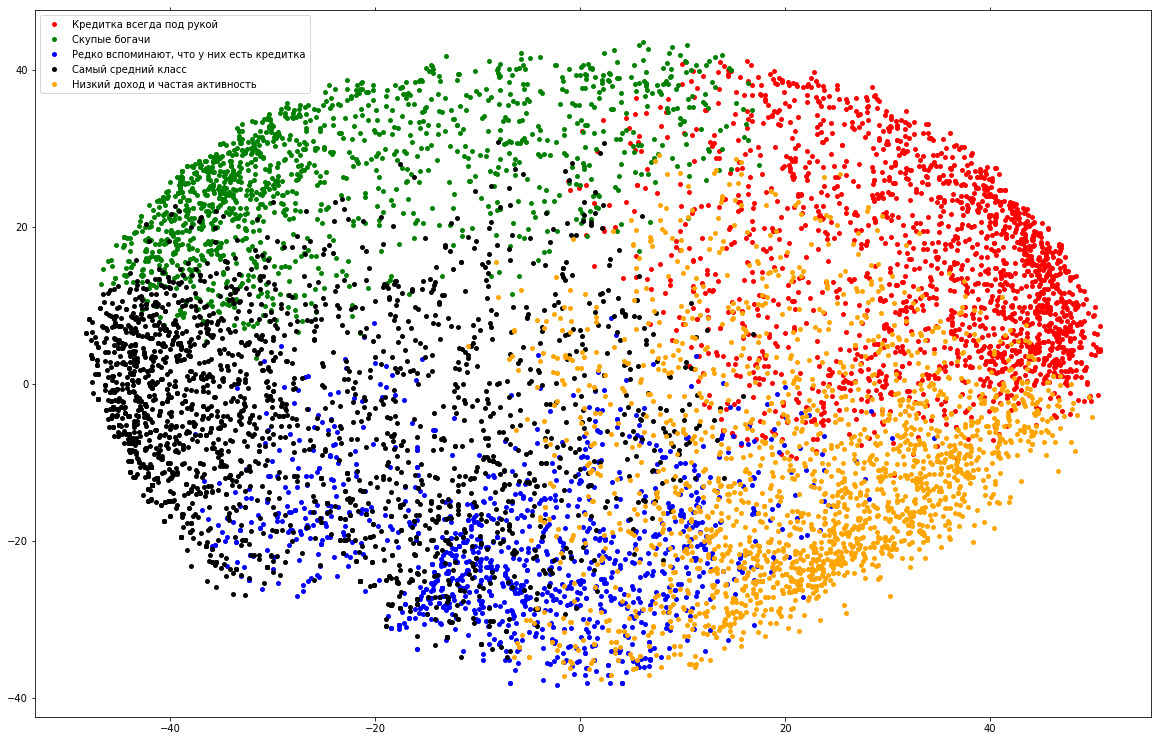

In [13]:
dist = 1 - cosine_similarity(X)
pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
x, y = X_PCA[:, 0], X_PCA[:, 1]
colors = {0: 'red',
          1: 'green',
          2: 'blue', 
          3: 'black', 
          4: 'orange'}
names = {0: 'Кредитка всегда под рукой', 
         1: 'Скупые богачи', 
         2: 'Редко вспоминают, что у них есть кредитка', 
         3: 'Самый средний класс', 
         4: 'Низкий доход и частая активность'}
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(20, 13)) 
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
ax.legend()